<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/Tutorial4_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE - Tutorial 4
## Optimization Tips & PyTorch Lightning
9 Feb & 11 Feb 2021

We'll be covering some tips on how to make optimization of neural nets easier, as well as a little PyTorch Lightning primer.

Specifically, we'll be covering:

1. Early Stopping
2. Lookahead
3. Activation Functions
4. Gradient Clipping
5. Skip connections


## Making the optimization task easier

There are two main approaches when tackling difficult-to-optimize tasks:

1. Traversing the loss landscape in more clever ways ("AWD")
2. Make the loss landscape easier to traverse ("Pavement")


## Traversing the loss landscape in more clever ways ("AWD")

### Early stopping

Naively, one might stop training when the training loss converges. Often, if the optimizer is converging towards a optimal or near-optimal solution, the testing loss will converge alongside the training loss (either with a similar value for optimal solutions, higher in the case of over-fitting).

However, the testing loss doesn't always converge alongside the training. Often enough, the training loss will continue to drop long after the testing converges. Continuing to train after testing converged can lead to overfitting, and the testing loss rising over time.

Some NN implementations deploy a really simple training policy called "Early Stopping".

The policy:

> If the testing loss hasn't improved by at least $\delta_\textrm{min}$ after $n$ steps, stop training.

$n$ is sometimes referred to as "patience".


#### Implementing Early Stopping (PyTorch)

In [ ]:
import torch
from torch.nn import functional as F
from torch import nn

class torchMNIST(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    # (b, 1, 28, 28) -> (b, 1*28*28)
    x = x.view(batch_size, -1)
    x = self.layer_1(x)
    x = F.relu(x)
    x = self.layer_2(x)
    x = F.relu(x)
    x = self.layer_3(x)

    return x


In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train_loader = DataLoader(mnist_train_data, batch_size=64)

mnist_test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=64)

In [ ]:
import numpy as np

def train(model, data, val_data, num_epoch, loss_func, optimizer, device = None, 
          patience = 3, min_delta = -0.0001):

    if device is None:
      device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # every time val_loss is less than min_delta, we'll add a strike
    # when strikes > patience, we'll quit training
    strikes = 0
    last_val_loss = None

    avg_val_losses = []
    avg_training_losses = []

    for i in range(num_epoch):
        model.train()

        training_losses = []
        for x, y in data:        
            # move the data to gpu
            x = x.to(device)
            y = y.to(device)
    
            # reset the gradients
            optimizer.zero_grad() 
    
            y_hat = model(x)
            batch_loss = loss_func(y_hat, y)
            batch_loss.backward() # autodiff
            optimizer.step() # weight update

            training_losses.append(batch_loss.item())

        avg_training_loss = np.mean(training_losses)
        avg_training_losses.append(avg_training_loss)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, y in data: 
              x = x.to(device)
              y = y.to(device)

              pred = model(x)
              val_loss = loss_func(pred, y)
              val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        avg_val_losses.append(avg_val_loss)


        # EARLY STOP LOGIC

        # if we don't have a previous loss, we'll skip the early stop logic
        if last_val_loss is None:
          print(i, batch_loss.item(), avg_val_loss)
          last_val_loss = avg_val_loss
          continue

        delta = avg_val_loss - last_val_loss

        if delta > min_delta:
          strikes += 1
          print(f"Strike {strikes}, with delta {delta}")
        else:
          # strike only accumulate if they occur one-after-the-other
          # to achieve this, we reset strikes on a epoch with loss > min_delta
          strikes = 0

        if strikes >= patience:
          print(f"Early stopping after {strikes} strikes.")
          return model
            
        print(i, avg_training_loss, avg_val_loss)
    return avg_training_losses, avg_val_losses

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torchMNIST().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
training_losses, val_losses = train(model, mnist_train_loader, mnist_test_loader, 5, loss, optimizer, device)

0 0.1210089772939682 0.2878110324685921
1 0.2560402560574032 0.21701545453370252
2 0.2014190049967103 0.17332854712290613
3 0.16474604562345915 0.14316480264647494
4 0.13833957458677482 0.12098184393456718


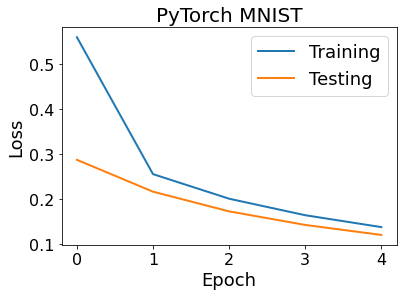

In [ ]:
import matplotlib.pyplot as plt

parameters = {'axes.labelsize': 18, 'legend.fontsize': 18, 'xtick.labelsize':16,
              'ytick.labelsize':16, 'axes.titlesize': 20}
plt.rcParams.update(parameters)

plt.plot(range(5), training_losses, lw=2, label='Training')
plt.plot(range(5), val_losses, lw=2, label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch MNIST')
plt.show()

#### Implementing Early Stopping (PyTorch Lightning)

We've be re-writing a lot of the same code from Tutorial 3.

Re-writing the same code can be error prone, increase prototyping time, and make code less readable.

PyTorch Lightning takes care of a lot of these concerns by taking care of the training loop. It also has useful pre-built functions like early stopping.

First, install PyTorch Lightning with pip

In [ ]:
!pip install pytorch-lightning

Then, let's define the neural network. This part is a lot like the PyTorch version.

In [ ]:
import pytorch_lightning as pl

# DIFFERENCE 1/4
# swapping nn.Module for pl.LightningModule

class LightningMNIST(pl.LightningModule):

  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    x = x.view(batch_size, -1)
    x = self.layer_1(x)
    x = F.relu(x)
    x = self.layer_2(x)
    x = F.relu(x)
    x = self.layer_3(x)
    
    return x

  # DIFFERENCE 2/4
  # Define a training step.
  # This is what is computed at every batch.
  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('training_loss', loss, on_step=False, on_epoch=True)
    return loss

  # DIFFERENCE 3/4
  # Define a validation step.
  # In our case, it's precisely the same as our training step.
  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('val_loss', loss)
    return loss

  # DIFFERENCE 4/4
  # We define the optimizer that the model will be using here
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

Data loading block is the same

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train_loader = DataLoader(mnist_train_data, batch_size=64)

mnist_test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=64)

Now, we can simply use the trainer function from PyTorch Lightning

In [ ]:
# Download this script to help logging
!curl -O https://dl.sphericalcow.xyz/ecse552/T4/dict_logger.py
from dict_logger import DictLogger

model = LightningMNIST()

logger = DictLogger()

trainer = pl.Trainer(max_epochs=5,                  # Maximum number of epochs to train
                     gpus=1,                        # Use one GPU
                     progress_bar_refresh_rate=30,  # Google Colab behaves badly if this is < 20
                     logger=logger
                     )

trainer.fit(model, mnist_train_loader, mnist_test_loader)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1635  100  1635    0     0  12111      0 --:--:-- --:--:-- --:--:-- 12111


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params


1

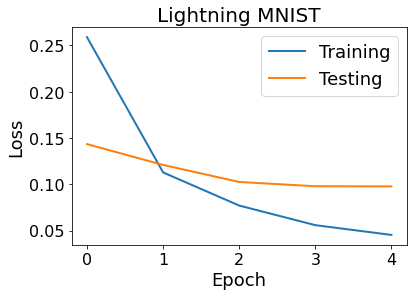

In [ ]:
plt.plot(range(5), logger.metrics['training_loss'], lw=2, label='Training')
plt.plot(range(5), logger.metrics['val_loss'], lw=2, label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Lightning MNIST')
plt.show()

To add early stopping, you can use the PyTorch Lightning Early Stopping callback.

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
   monitor='val_loss', # Monitor the validation loss.
   min_delta=0.00, # Minimum change is 0
   patience=3, # Number of epochs with improvements less than min_delta that will be tolerated.
   verbose=True # Log early-stop events
)

trainer = pl.Trainer(max_epochs=4,                  
                     gpus=1,                        
                     callbacks=[early_stop_callback], # The early stop callback is added here
                     progress_bar_refresh_rate=30   
                     )

trainer.fit(model, mnist_train_loader, mnist_test_loader)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params


1

### Lookahead Optimizers

To traverse the loss landscape more easily, we can implement some optimization tricks.

One really intuitive and promising trick is Lookahead, where two sets of weights are trained with two sets of learning rates; a fast one and a slow one.

The fast weights "scout ahead" in the loss landscape, while the slow weights take the midpoint between the current slow weights and the current fast weights.

For more details, check out [this talk](https://www.youtube.com/watch?v=TxGxiDK0Ccc) by the first author of the [Lookahead paper](https://arxiv.org/pdf/1907.08610.pdf).

![A diagram of lookahead optimization from the original lookahead paper](https://dl.sphericalcow.xyz/ecse552/T4/lookahead.png)

When you use Lookahead with the [Rectified Adam](https://arxiv.org/abs/1908.03265) optimizer, it is [sometimes called "Ranger"](https://lessw.medium.com/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d).

We can use ranger super easily using the [pytorch-optimizer](https://pytorch-optimizer.readthedocs.io/en/latest/) library which expands the number of optimizer implementations from the PyTorch library.

In [ ]:
!pip install torch_optimizer

     |████████████████████████████████| 81kB 8.6MB/s 


In [ ]:
import torch_optimizer as optim

In [ ]:
class RangerMNIST(pl.LightningModule):

  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    x = x.view(batch_size, -1)
    x = self.layer_1(x)
    x = F.relu(x)
    x = self.layer_2(x)
    x = F.relu(x)
    x = self.layer_3(x)

    return x

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('training_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    # DIFFERENCE
    # Use the Ranger optimizer here
    return optim.RangerQH(self.parameters(), lr=1e-3, k=6)

In [ ]:
model = RangerMNIST()

logger = DictLogger()

trainer = pl.Trainer(max_epochs=5, gpus=1, progress_bar_refresh_rate=30, logger=logger)

trainer.fit(model, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params


/usr/local/lib/python3.6/dist-packages/pytorch_ranger/rangerqh.py:152: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)


1

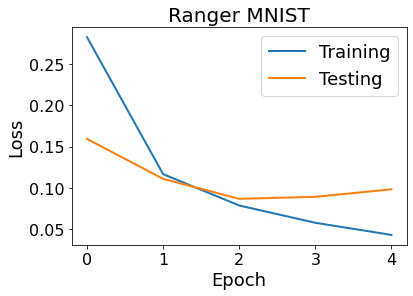

In [ ]:
plt.plot(range(5), logger.metrics['training_loss'], lw=2, label='Training')
plt.plot(range(5), logger.metrics['val_loss'], lw=2, label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ranger MNIST')
plt.show()

## Make the loss landscape easier to traverse ("Pavement")

### Choosing Activation Functions

As you've seen in class, there is a variety of activation functions to choose from. They typically balance: 
1. Nature of non-linearity
2. How slow computing the derivative is

#### Rectified Linear Units (ReLU) and Leaky ReLU

ReLUs are super popular because their derivative is super quick to compute and
has shown to perform well for most tasks.



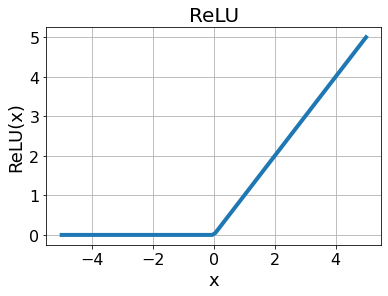

In [ ]:
import numpy as np

X = np.linspace(-5,5,100)

def relu(x):
  y = x.copy()
  y[x < 0] = 0
  return y

plt.plot(X, relu(X), lw=4)
plt.title('ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid()
plt.show()

It has one major problem, and that's the "Dying ReLU" problem. Because all negative values are mapped to 0, negative weights can snowball into massive magnitudes and ostensibly get stuck at 0 (a dead neuron).

Adding a tiny slope to the negative values can really help this.

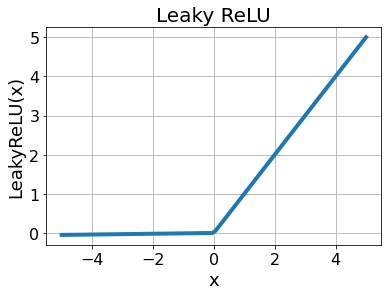

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(-5,5,100)

def leaky_relu(x, alpha = 0.01):
  y = x.copy()
  y[x < 0] = y[x < 0]*alpha
  return y

plt.plot(X, leaky_relu(X), lw=4)
plt.title('Leaky ReLU')
plt.xlabel('x')
plt.ylabel('LeakyReLU(x)')
plt.grid()
plt.show()

#### Mish

The Mish function is a relatively new activation function which has been employed to address the "sharp" output spaces that ReLU often generates.

View a [3D visualization](https://losslandscape.com/explorer?model=mish) of the loss landscape of ReLU compared to Mish.

![Mish output space figure from figure 3 of the Mish paper](https://dl.sphericalcow.xyz/ecse552/T4/mish.png)

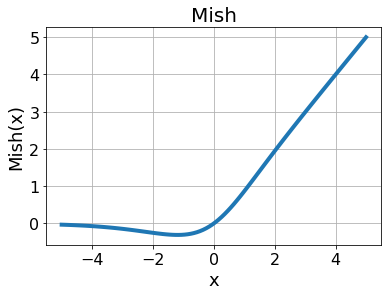

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(-5,5,100)

def softplus(x):
  return np.log(1+np.exp(x))

def mish(x, alpha = 0.01):
  y = x.copy()
  y = y*np.tanh(softplus(y))
  return y

plt.plot(X, mish(X), lw=4)
plt.title('Mish')
plt.xlabel('x')
plt.ylabel('Mish(x)')
plt.grid()
plt.show()

#### Using Mish

Here's our MNIST example with Mish and Ranger.

First, we define the Mish function. We can define it as a PyTorch Module so that we can seamlessly swap it with other activation functions.

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
class RangerMishMNIST(pl.LightningModule):

  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128, 256)
    self.layer_3 = torch.nn.Linear(256, 10)
    self.mish = Mish() # DIFFERENCE (1/3)

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    x = x.view(batch_size, -1)
    x = self.layer_1(x)
    x = self.mish(x) # DIFFERENCE (2/3)
    x = self.layer_2(x)
    x = self.mish(x) # DIFFERENCE (3/3)
    x = self.layer_3(x)

    return x

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('training_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return optim.RangerQH(self.parameters(), lr=1e-3, k=6)

In [ ]:
model = RangerMishMNIST()

logger = DictLogger()

trainer = pl.Trainer(max_epochs=5, gpus=1, progress_bar_refresh_rate=30, logger=logger)

trainer.fit(model, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
3 | mish    | Mish   | 0     
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params


1

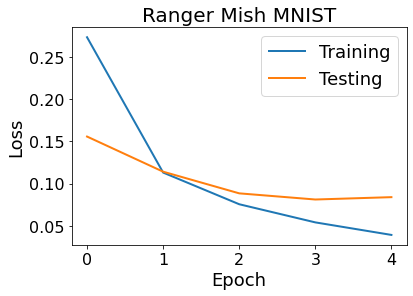

In [ ]:
plt.plot(range(5), logger.metrics['training_loss'], lw=2, label='Training')
plt.plot(range(5), logger.metrics['val_loss'], lw=2, label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ranger Mish MNIST')
plt.show()

### Skip-Connections


In [ ]:
class SkipMNIST(pl.LightningModule):

  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear(28 * 28, 128)
    self.layer_2 = torch.nn.Linear(128 + (28 * 28), 256)
    self.layer_3 = torch.nn.Linear(256 + 128, 10)
    self.mish = Mish()

  def forward(self, x):
    batch_size, channels, width, height = x.size()

    x = x.view(batch_size, -1)

    x1 = self.layer_1(x)
    x1 = self.mish(x1) 

    x2 = torch.cat((x1, x), dim=1)
    x2 = self.layer_2(x2)
    x2 = self.mish(x2)

    x3 = torch.cat((x1, x2), dim=1)
    x3 = self.layer_3(x3)

    return x3

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('training_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return optim.RangerQH(self.parameters(), lr=1e-3, k=6)

In [ ]:
model = SkipMNIST()

logger = DictLogger()

trainer = pl.Trainer(max_epochs=5, gpus=1, progress_bar_refresh_rate=30, logger=logger)

trainer.fit(model, mnist_train_loader, mnist_test_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 233 K 
2 | layer_3 | Linear | 3.9 K 
3 | mish    | Mish   | 0     
-----------------------------------
338 K     Trainable params
0         Non-trainable params
338 K     Total params


1

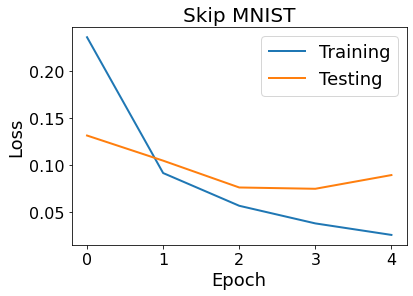

In [ ]:
plt.plot(range(5), logger.metrics['training_loss'], lw=2, label='Training')
plt.plot(range(5), logger.metrics['val_loss'], lw=2, label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Skip MNIST')
plt.show()